## Imports

In [26]:
import pandas as pd
from MainPackage import MixtureModelBernoulli
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
import time

# Run model

In [2]:
num_classes = 4
random_state = 100

# Get data
df = pd.read_csv("../Data/test_data.csv",index_col=0)

# Set up model
C_list = MixtureModelBernoulli(num_classes=num_classes,
                               random_state=random_state,
                               burn_in=0,
                               max_iter=1000)


# fit the data to the model
start_time = time.time()
C_list.fit(df)
total_time = time.time() - start_time

print("DONE!")
print(f"Total time: {round(total_time,5)} (secs)")

# Get parameter estimates
k, theta, pi = C_list.get_params()

DONE!
Total time: 58.90766 (secs)


# Print Parameters

## Pi

In [3]:
pi = pd.DataFrame(pi)
pi.columns = ["Probability"]
pi.index = [f"Cluster {x}" for x in np.arange(1,len(pi)+1).astype(str)]
display(pi)

,Probability
Cluster 1,0.239703
Cluster 2,0.209006
Cluster 3,0.150529
Cluster 4,0.400762


## Theta

In [4]:
theta = pd.DataFrame(theta)
theta.columns = [f"Item {x}" for x in np.arange(1,theta.shape[1]+1).astype(str)]
theta.index = [f"Cluster {x}" for x in np.arange(1,theta.shape[0]+1).astype(str)]
display(theta)

,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,Item 10,Item 11,Item 12,Item 13,Item 14,Item 15,Item 16,Item 17,Item 18,Item 19,Item 20
Cluster 1,0.038805,0.050385,0.022005,0.266082,0.263162,0.202136,0.011317,0.446695,0.267847,0.035089,0.079324,0.143288,0.008792,0.067290,0.022422,0.096861,0.030858,0.020728,0.008984,0.014883
Cluster 2,0.106141,0.145801,0.056752,0.243251,0.368816,0.845983,0.090301,0.623819,0.659544,0.102830,0.239260,0.790660,0.051685,0.837234,0.094220,0.810373,0.243770,0.222528,0.037491,0.189771
Cluster 3,0.858370,0.919455,0.904022,0.351132,0.614798,0.964718,0.442521,0.784711,0.575160,0.144906,0.237213,0.761992,0.040907,0.853304,0.421404,0.790685,0.090891,0.334376,0.053374,0.029018
Cluster 4,0.833942,0.911551,0.832127,0.868843,0.812942,0.973005,0.756740,0.938356,0.804402,0.813222,0.935221,0.957791,0.684216,0.958300,0.876455,0.924810,0.882417,0.836948,0.719698,0.874188


# K

In [5]:
k = pd.DataFrame(k)
k.columns = ["Avg Class"]
k.index = [f"Cluster {x}" for x in np.arange(1,len(k)+1).astype(str)]
display(k)

,Avg Class
Cluster 1,0.000000
Cluster 2,0.001001
Cluster 3,0.013013
Cluster 4,0.998999
Cluster 5,0.924925
...,...
Cluster 996,0.002002
Cluster 997,0.002002
Cluster 998,0.013013
Cluster 999,0.931932


## Class Membership

In [6]:
memebership = C_list.get_class_membership_scores()
memebership = pd.DataFrame(memebership)
memebership.columns = [f"Subject {x}" for x in np.arange(1,memebership.shape[1]+1).astype(str)]
memebership.index = [f"Cluster {x}" for x in np.arange(1,memebership.shape[0]+1).astype(str)]
display(memebership)

,Subject 1,Subject 2,Subject 3,Subject 4
Cluster 1,0.999677,0.000323,1.587537e-08,1.877669e-17
Cluster 2,0.999071,0.000929,8.636956e-08,3.722861e-15
Cluster 3,0.995647,0.004350,3.259005e-06,1.142835e-13
Cluster 4,0.009940,0.942848,4.721184e-02,1.098213e-08
Cluster 5,0.001716,0.998035,2.493465e-04,3.662994e-10
...,...,...,...,...
Cluster 996,0.999677,0.000323,1.587537e-08,1.877669e-17
Cluster 997,0.998822,0.001178,8.704578e-08,5.497266e-15
Cluster 998,0.991157,0.008843,2.648079e-07,1.981446e-16
Cluster 999,0.000016,0.999709,2.756909e-04,7.808352e-08


# Analyze Convergence for thetas

In [7]:
np.random.RandomState(100)
number_of_rows = 5
number_of_cols = 2

(999, 4, 20)


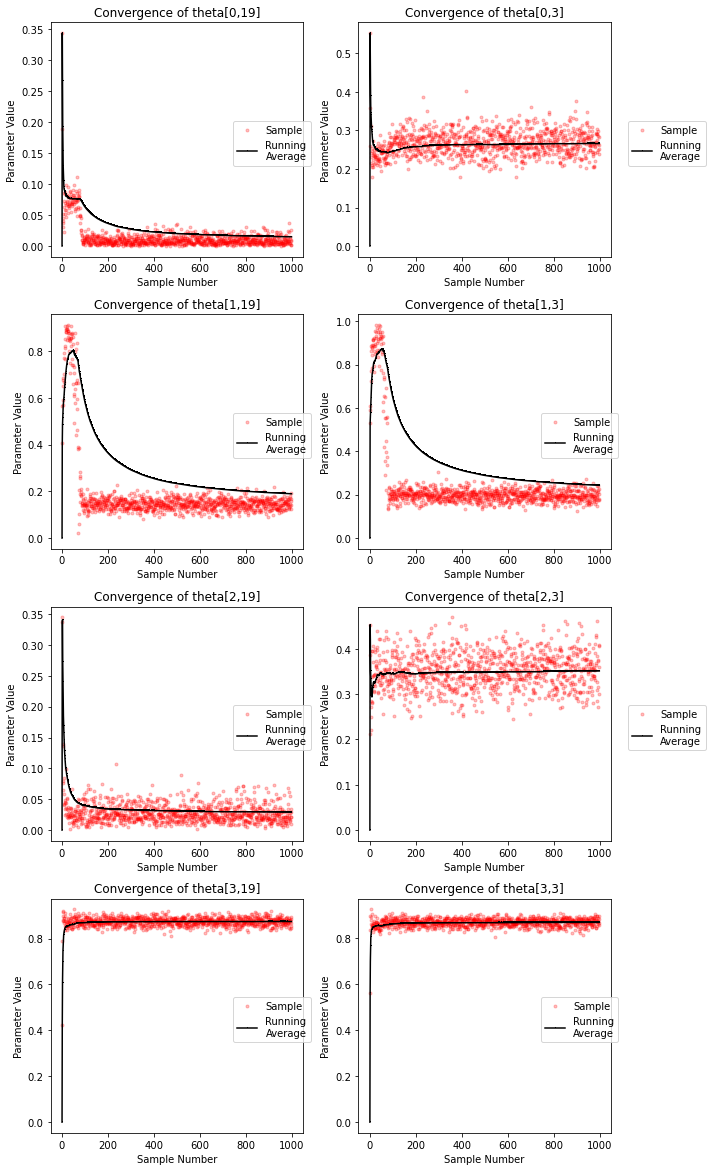

In [8]:
samples_theta_params = C_list.samples_theta_params
print(samples_theta_params.shape)

# Get random indexes
c_range = [0,1,2,3]
j_range = np.random.choice(np.arange(0,samples_theta_params.shape[2]),number_of_cols)


plt.figure(figsize=(10,20))
num_plot = 1
for c in c_range:
    for j in j_range:
        running_avg = np.zeros(samples_theta_params.shape[0])
        for num_sample in range(1,samples_theta_params.shape[0]):
            running_avg[num_sample] = np.average(samples_theta_params[:num_sample, c, j])

        plt.subplot(number_of_rows,number_of_cols,num_plot)
        plt.plot(samples_theta_params[:, c, j], ".r", label="Sample",alpha=.25)
        plt.plot(running_avg, "-k,", label="Running\nAverage")
        plt.xlabel("Sample Number")
        plt.ylabel("Parameter Value")
        plt.title(f"Convergence of theta[{c},{j}]")
        plt.legend(bbox_to_anchor = (1.05, 0.6))
        num_plot += 1
plt.tight_layout()

# Convergence Analysis for k

(999, 1000)


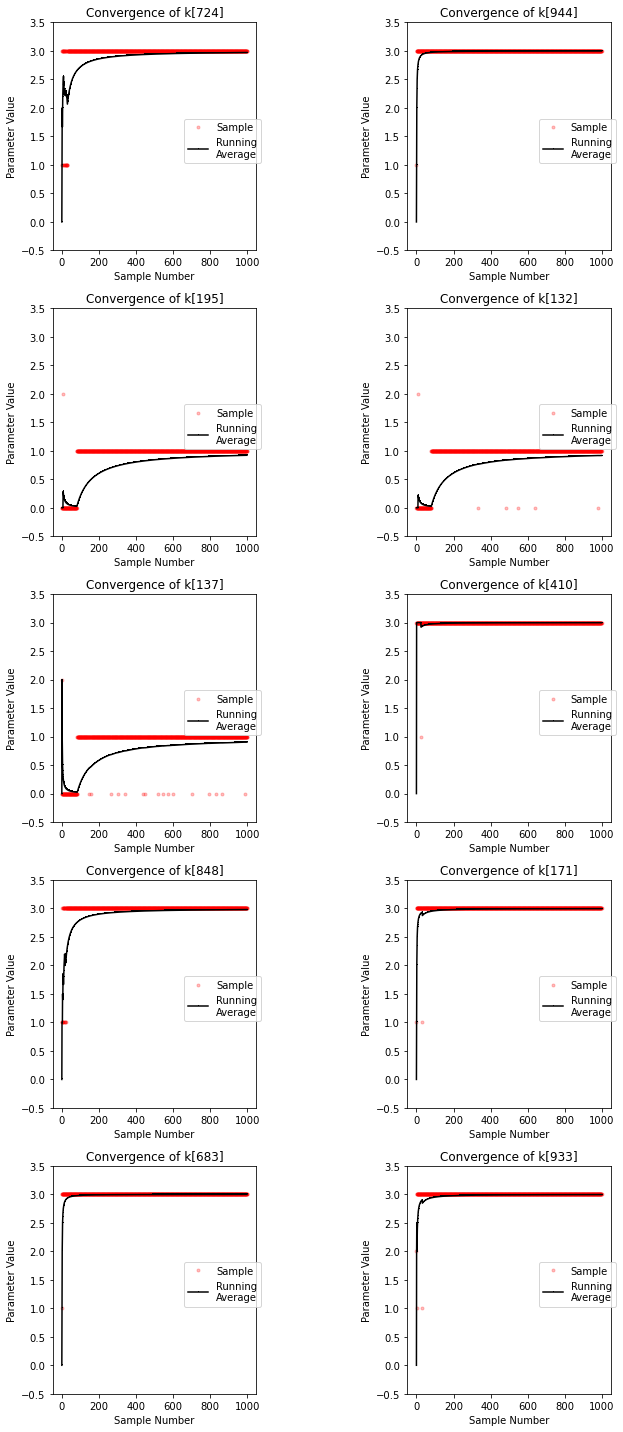

In [9]:
samples_class_assignments = C_list.samples_class_assignments
print(samples_class_assignments.shape)

# Get random indexes
i_range = np.random.choice(np.arange(0,samples_class_assignments.shape[1]),number_of_cols*number_of_rows)

plt.figure(figsize=(10,20))
num_plot = 1
for i in i_range:
    running_avg = np.zeros(samples_class_assignments.shape[0])
    for num_sample in range(1,samples_class_assignments.shape[0]):
        running_avg[num_sample] = np.average(samples_class_assignments[:num_sample, i])

    plt.subplot(number_of_rows,number_of_cols,num_plot)
    plt.plot(samples_class_assignments[:, i], ".r", label="Sample",alpha=.25)
    plt.plot(running_avg, "-k,", label="Running\nAverage")
    plt.xlabel("Sample Number")
    plt.ylabel("Parameter Value")
    plt.title(f"Convergence of k[{i}]")
    plt.legend(bbox_to_anchor = (1.05, 0.6))
    plt.ylim(-.5,3.5)
    num_plot += 1
plt.tight_layout()

# Convergence Analysis for pi

(999, 4)


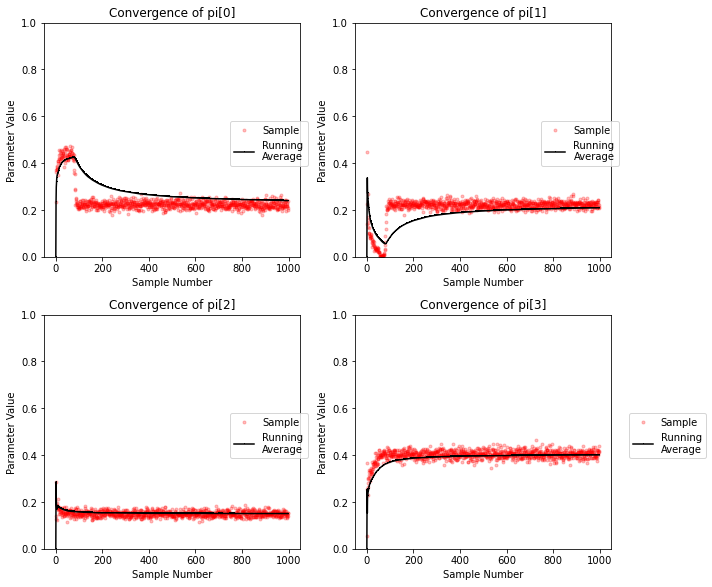

In [10]:
samples_class_probabilities = C_list.samples_class_probabilities
print(samples_class_probabilities.shape)


plt.figure(figsize=(10,20))
num_plot = 1
for c in c_range:
    running_avg = np.zeros(samples_class_probabilities.shape[0])
    for num_sample in range(1,samples_class_probabilities.shape[0]):
        running_avg[num_sample] = np.average(samples_class_probabilities[:num_sample, c])

    plt.subplot(number_of_rows,number_of_cols,num_plot)
    plt.plot(samples_class_probabilities[:, c], ".r", label="Sample",alpha=.25)
    plt.plot(running_avg, "-k,", label="Running\nAverage")
    plt.xlabel("Sample Number")
    plt.ylabel("Parameter Value")
    plt.title(f"Convergence of pi[{c}]")
    plt.legend(bbox_to_anchor = (1.05, 0.6))
    plt.ylim(0,1)
    num_plot += 1
plt.tight_layout()

# Comparing K vectors with Adjusted Rand Score
Adjusted rand score is a score between [0,1] which compares two clusterings. 1 indicating the same clustering, and 0 indicating random cluster labels.

In [28]:
# Get true k vector
df_true_k = pd.read_csv("../Data/test_k_vector.csv",index_col=0)

# round predicted k
df_predicted_k = k.round().astype(np.int64)
df_predicted_k.columns = ["Class"]
rand_score = adjusted_rand_score(df_true_k["Class"],df_predicted_k["Class"])

ValueError: Found input variables with inconsistent numbers of samples: [536, 1000]

,Avg Class
Cluster 1,0.000000
Cluster 2,0.001001
Cluster 3,0.013013
Cluster 4,0.998999
Cluster 5,0.924925
...,...
Cluster 996,0.002002
Cluster 997,0.002002
Cluster 998,0.013013
Cluster 999,0.931932
